<div style="text-align:center;font-size:22pt; font-weight:bold;color:white;border:solid black 1.5pt;background-color:#1e7263;">
    03. Model Capacity in Deep Leanring: Practical Project <br> Bank Marketing Prediction
</div>

In [1]:
# ======================================================================= #
# Course: Deep Learning Complete Course (CS-501)
# Author: Dr. Saad Laouadi
# Institution: Quant Coding Versity Academy
#
# ==========================================================
# Lesson: Practice Model Capacity In Deep Learning
#         Hands-on Project 
# ==========================================================
# Learning Objectives
# ===================
# 1. Explore the data
# 2. Preprocess the data
# 3. Save the preprocessed data
# =======================================================================
#          Copyright © Dr. Saad Laouadi 2025
# =======================================================================

In [2]:
# ============================================================================ #
#                         Environment Path Configuration                       #
# ============================================================================ #
#
# Purpose:
#   Configure the system PATH to use Python executables from the active virtual 
#   environment instead of global installations.
#
# Usage:
#   1. First verify if configuration is needed by running: !which python
#   2. If the output shows the global Python installation rather than your 
#      virtual environment, execute this configuration block
#
# Note:
#   This configuration is typically only needed for JupyterLab Desktop or 
#   similar standalone installations. Web-based JupyterLab or properly 
#   configured environments should not require this adjustment.
# ============================================================================ #

import os
import sys

env_path = os.path.dirname(sys.executable)
os.environ['PATH'] = f"{env_path}:{os.environ['PATH']}"

In [3]:
# ==================================================== #
#        Load Required Libraries
# ==================================================== #

from pprint import pprint
import requests
import zipfile
import io
from pathlib import Path
import shutil
from datetime import datetime
from typing import Tuple, Dict, List, Union


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import optuna

from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_slice
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_rank

import tensorflow as tf

print("="*72)

%reload_ext watermark
%watermark -a "Dr. Saad Laouadi" -u -d -m

print("="*72)
print("Imported Packages and Their Versions:")
print("="*72)

%watermark -iv
print("="*72)

# Global Config
RANDOM_STATE = 101

Author: Dr. Saad Laouadi

Last updated: 2025-01-23

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Imported Packages and Their Versions:
optuna    : 4.1.0
numpy     : 1.26.4
requests  : 2.32.3
sklearn   : 1.5.1
seaborn   : 0.13.2
tensorflow: 2.16.2
pandas    : 2.2.2
matplotlib: 3.9.2
imblearn  : 0.0
sys       : 3.11.10 (main, Oct  3 2024, 02:26:51) [Clang 14.0.6 ]



In [4]:
# ========================================================================= #
#         Preprocessing Utility Functions
# ========================================================================= #
def load_data(filepath: str, sep: str = ";") -> pd.DataFrame:
    """Loads the bank marketing dataset and performs initial cleaning.

    Args:
        filepath: Path to the dataset CSV file
        sep: Delimiter used in the CSV file, defaults to semicolon

    Returns:
        Cleaned pandas DataFrame with lowercase column names and stripped string values

    Examples:
        >>> df = load_data("bank_marketing.csv")
        >>> df = load_data("marketing.csv", sep=",")
    """
    # Read the dataset
    df = pd.read_csv(filepath, sep=sep)
    
    # Convert column names to lowercase
    df.columns = df.columns.str.lower()
    
    # Strip whitespace from string columns
    object_columns = df.select_dtypes(include=['object']).columns
    df[object_columns] = df[object_columns].apply(lambda x: x.str.strip())
    
    return df


def display_basic_info(df: pd.DataFrame) -> None:
    """Displays comprehensive overview of a pandas DataFrame.

    Prints multiple aspects of the DataFrame including shape, first rows,
    memory usage, datatypes, and statistical summary of numeric columns.

    Args:
        df (pd.DataFrame): The pandas DataFrame to analyze.

    Returns:
        None: This function prints output but does not return any value.
    """
    print("="*72)
    print("Dataset Overview:")
    print("="*72)
    print("\nDataset Shape:", df.shape)
    print("\nFirst few rows:")
    print(df.head())
    
    print("\nDataset Information:")
    print("="*72)
    df.info()
    
    print("\nStatistical Summary:")
    print("="*72)
    print(df.describe())
    
    
def get_feature_groups(df: pd.DataFrame) -> Tuple[List[str], List[str]]:
    """Separates features into numerical and categorical groups.
    
    Takes a pandas DataFrame and identifies numerical and categorical columns,
    excluding the target variable 'y' if present.
    
    Args:
        df: A pandas DataFrame containing the features to be separated.
        
    Returns:
        A tuple containing:
            numeric_features (List[str]): List of numerical column names
            categorical_features (List[str]): List of categorical column names
    """
    # Identify numeric and categorical columns
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    
    # Remove target variable if present
    if 'y' in numeric_features:
        numeric_features.remove('y')
    if 'y' in categorical_features:
        categorical_features.remove('y')
    
    return numeric_features, categorical_features


def analyze_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """Analyzes missing values in the dataset.
    
    Args:
        df (pd.DataFrame): Input dataset
        
    Returns:
        pd.DataFrame: Missing value analysis
    """
    # Calculate missing value statistics
    missing = pd.DataFrame({
        'count': df.isnull().sum(),
        'percentage': (df.isnull().sum() / len(df) * 100).round(2)
    })
    
    return missing[missing['count'] > 0].sort_values('percentage', ascending=False)


def analyze_target_distribution(df: pd.DataFrame,  target_col: str = 'y',
                                print_info: bool = True,
                               ) -> Dict[str, Union[Dict, float]]:
    """Analyzes the distribution of the target variable.
    
    Args:
        df (pd.DataFrame): Input dataset
        target_col (str): Name of the target columns. Defaults to 'y'.
        print_info (bool): Whether to print the information. Defaults to True.
    Returns:
        Dict[str, float]: Target distribution statistics
    """
    # Calculate distributions and counts
    target_counts = df[target_col].value_counts()
    target_dist = target_counts / len(df)
    
    # Identify majority and minority classes
    majority_class = target_counts.idxmax()
    minority_class = target_counts.idxmin()
    
    # Calculate imbalance ratio
    imbalance_ratio = float(target_counts.min()) / float(target_counts.max())
    
    # Prepare results
    results = {
        'distribution': {k: round(float(v), 3) 
                        for k, v in target_dist.to_dict().items()},
        'counts': target_counts.to_dict(),
        'imbalance_ratio': round(imbalance_ratio, 3),
        'majority_class': majority_class,
        'minority_class': minority_class
    }
    
    # Print summary
    if print_info:
        print("\nTarget Distribution Analysis:")
        print(f"✓ Total samples: {len(df)}")
        print(f"✓ Number of classes: {len(target_counts)}")
        print(f"✓ Majority class ({majority_class}): {target_counts.max()} samples "
              f"({target_dist.max():.1%})")
        print(f"✓ Minority class ({minority_class}): {target_counts.min()} samples "
              f"({target_dist.min():.1%})")
        print(f"✓ Imbalance ratio: {imbalance_ratio:.3f}")
    
    return results


def plot_target_distribution(df: pd.DataFrame,target_col: str = 'y',
                             figsize: Tuple[int, int] = (10, 6),
                             palette: str = 'viridis',
                             rotation: int = 0) -> None:
    """Creates a visualization of target variable distribution.
    
    Generates a bar plot showing the distribution of classes in the target variable,
    including count and percentage labels.
    
    Args:
        df (pd.DataFrame): The input dataset containing the target variable.
        target_col (str): Name of the target column. Defaults to 'y'.
        figsize (Tuple[int, int]): Figure size as (width, height). Defaults to (10, 6).
        palette (str): Color palette for the plot. Defaults to 'viridis'.
        rotation (int): Rotation angle for x-axis labels. Defaults to 0.
        
    Raises:
        KeyError: If target_col is not found in the DataFrame.
        ValueError: If DataFrame is empty or target contains invalid values.
        
    Example:
        >>> df = pd.DataFrame({'y': [0, 0, 0, 1, 1]})
        >>> plot_target_distribution(df)
    """
    # Calculate distribution
    target_counts = df[target_col].value_counts()
    target_percentages = (target_counts / len(df) * 100).round(1)
    
    # Create figure and axis
    plt.figure(figsize=figsize)
    
    # Create bar plot
    ax = sns.barplot(
        x=target_counts.index,
        y=target_counts.values,
        hue=target_counts.index,  
        palette=palette,
        legend=False  
    )
    
    # Add count and percentage labels on bars
    for i, (count, percentage) in enumerate(zip(target_counts, target_percentages)):
        ax.text(
            i, count/2,
            f'n = {count}\n({percentage}%)',
            ha='center',
            va='center',
            color='white',
            fontweight='bold'
        )
    
    # Customize plot
    plt.title(
        f'Distribution of {target_col}\n(Total samples: {len(df)})',
        pad=20
    )
    plt.xlabel(f'{target_col} Classes')
    plt.ylabel('Count')
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=rotation)
    
    # Add grid for better readability
    plt.grid(True, axis='y', alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()


def generate_data_summary(df: pd.DataFrame, target_col: str = 'y') -> Dict:
    """
    Generate a comprehensive summary of the dataset.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        target_col (str): Name of the target column. Defaults to 'y'.
        
    Returns:
        Dict: Summary statistics and information
    """    
    # Get feature groups
    numeric_features, categorical_features = get_feature_groups(df)
   
    # Generate summary dictionary
    summary = {
       'dataset_shape': df.shape,
       'numeric_features': {
           'count': len(numeric_features),
           'names': numeric_features,
           'statistics': df[numeric_features].describe().round(2).to_dict()
       },
       'categorical_features': {
           'count': len(categorical_features),
           'names': categorical_features,
           'unique_values': {col: df[col].nunique() for col in categorical_features},
           'value_counts': {col: df[col].value_counts().to_dict() 
                          for col in categorical_features}
       },
       'target_distribution': analyze_target_distribution(df, target_col=target_col, 
                                                          print_info=False),
       'missing_values': analyze_missing_values(df).to_dict()
    }
   
    # Print summary overview
    print("\nDataset Summary:")
    print(f"✓ Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"✓ Numeric Features: {len(numeric_features)}")
    print(f"✓ Categorical Features: {len(categorical_features)}")
    print(f"✓ Missing Values: {df.isnull().sum().sum()} total")
    print(f"✓ Memory Usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

    return summary


def preprocess_numeric_features(df: pd.DataFrame,
                                numeric_features: List[str]
                               ) -> Tuple[pd.DataFrame, StandardScaler]:
    """
    Preprocess numerical features using StandardScaler.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        numeric_features (List[str]): List of numerical feature names
        
    Returns:
        Tuple[pd.DataFrame, StandardScaler]: Preprocessed data and fitted scaler
    """
    scaler = StandardScaler()
    df_processed = df.copy()
    
    # Scale numeric features
    df_processed[numeric_features] = scaler.fit_transform(df[numeric_features])
    
    return df_processed, scaler


def encode_categorical_features(df: pd.DataFrame,
                              categorical_features: List[str]
                             ) -> Tuple[pd.DataFrame, OneHotEncoder]:
    """
    Encode categorical features using OneHotEncoder.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        categorical_features (List[str]): List of categorical feature names
        
    Returns:
        Tuple[pd.DataFrame, OneHotEncoder]: DataFrame with one-hot encoded features 
        and the fitted encoder
    """
    df_encoded = df.copy()
    
    # Initialize OneHotEncoder with appropriate parameters
    encoder = OneHotEncoder(
        sparse_output=False,      # Return dense array instead of sparse matrix
        handle_unknown='ignore',  # Handle new categories in test data
        drop='first'              # Drop first category for categorical features to avoid multicollinearity
    )
    
    # Fit and transform the categorical features
    encoded_features = encoder.fit_transform(df[categorical_features])
    
    # Get feature names after encoding
    feature_names = encoder.get_feature_names_out(categorical_features)
    
    # Create a DataFrame with encoded features
    encoded_df = pd.DataFrame(
        encoded_features,
        columns=feature_names,
        index=df.index
    )
    
    # Drop original categorical columns
    df_encoded = df_encoded.drop(columns=categorical_features)
    
    # Concatenate encoded features with original numeric features
    df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
    
    return df_encoded, encoder


def encode_target(df: pd.DataFrame, target_column: str) -> Tuple[pd.DataFrame, LabelEncoder]:
    """
    Encode the target variable using LabelEncoder.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        target_column (str): Name of the target column
        
    Returns:
        Tuple[pd.DataFrame, LabelEncoder]: DataFrame with encoded target and the fitted encoder
    """
    df_encoded = df.copy()
    encoder = LabelEncoder()
    
    # Fit and transform the target variable
    df_encoded[target_column] = encoder.fit_transform(df[target_column])
    
    return df_encoded, encoder


def plot_numeric_distributions(df: pd.DataFrame, 
                               numeric_features: List[str],
                               target_col: str = 'y') -> None:
    """
    Plot distributions of numeric features with respect to target variable.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        numeric_features (List[str]): List of numerical feature names
        target_col (str): Name of target column
    """
    n_features = len(numeric_features)
    n_cols = 2
    n_rows = (n_features + 1) // 2
    
    plt.figure(figsize=(15, 5 * n_rows))
    
    for i, feature in enumerate(numeric_features, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.boxplot(x=target_col, y=feature, data=df)
        plt.title(f'Distribution of {feature} by {target_col}')
        
    plt.tight_layout()
    plt.show()

    
def plot_categorical_distributions(df: pd.DataFrame, 
                                   categorical_features: List[str],
                                   target_col: str = 'y') -> None:
    """
    Plot distributions of categorical features with respect to target variable.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        categorical_features (List[str]): List of categorical feature names
        target_col (str): Name of target column
    """
    n_features = len(categorical_features)
    n_cols = 2
    n_rows = (n_features + 1) // 2
    
    plt.figure(figsize=(15, 5 * n_rows))
    
    for i, feature in enumerate(categorical_features, 1):
        plt.subplot(n_rows, n_cols, i)
        df_grouped = df.groupby(feature)[target_col].value_counts(normalize=True).unstack()
        df_grouped.plot(kind='bar', stacked=True)
        plt.title(f'Distribution of {target_col} by {feature}')
        plt.legend(title=target_col)
        plt.xticks(rotation=45)
        
    plt.tight_layout()
    plt.show()
    
    
def plot_categorical_distributions(df: pd.DataFrame, 
                                   categorical_features: List[str],
                                   target_col: str = 'y',
                                   figsize: Tuple[int, int] = (20, 6)
                                  ) -> None:
    """Plot distributions of categorical features with respect to target variable.
    
    Args:
        df: Input dataset containing features and target
        categorical_features: List of categorical feature names to plot
        target_col: Name of target column. Defaults to 'y'
        figsize: Base figure size as (width, height). Defaults to (20, 6)
    """
    # Input validation
    if not categorical_features:
        raise ValueError("categorical_features list cannot be empty")
        
    if target_col not in df.columns:
        raise KeyError(f"Target column '{target_col}' not found in DataFrame")
        
    missing_cols = [col for col in categorical_features if col not in df.columns]
    if missing_cols:
        raise KeyError(f"Features not found in DataFrame: {missing_cols}")
    
    # Calculate layout
    n_features = len(categorical_features)
    n_cols = min(2, n_features)  # Ensure we don't create empty subplots
    n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division
    
    # Create figure and axes
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(figsize[0], figsize[1] * n_rows),
        squeeze=False  # Always return 2D array of axes
    )
    
    # Create plots
    for idx, feature in enumerate(categorical_features):
        # Get current axis
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        # Calculate distributions
        df_grouped = df.groupby(feature)[target_col].value_counts(normalize=True).unstack()
        
        # Create plot
        df_grouped.plot(
            kind='bar', 
            stacked=True,
            ax=ax,
            width=0.8  # Slightly wider bars
        )
        
        # Customize plot
        ax.set_title(f'Distribution of {target_col} by {feature}', pad=10)
        ax.set_xlabel(feature)
        ax.set_ylabel('Proportion')
        
        # Rotate labels and adjust
        ax.tick_params(axis='x', rotation=45)
        
        # Move legend to right of plot
        ax.legend(
            title=target_col,
            bbox_to_anchor=(1.05, 1),
            loc='upper left'
        )
    
    # Remove empty subplots if any
    for idx in range(n_features, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        fig.delaxes(axes[row, col])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

In [5]:
def preprocess_data(df: pd.DataFrame,
                    categorical_features: List[str],
                    numeric_features: List[str],
                    target_column: str
                   ) -> Tuple[pd.DataFrame, OneHotEncoder, StandardScaler, LabelEncoder]:
    """
    Preprocess the data by applying transformations in the correct order:
    1. Encode categorical features
    2. Scale numeric features
    3. Encode target variable
    
    Parameters:
        df (pd.DataFrame): Input dataset
        categorical_features (List[str]): List of categorical feature names
        numeric_features (List[str]): List of numerical feature names
        target_column (str): Name of the target column
        
    Returns:
        Tuple containing:
        - Preprocessed DataFrame
        - Fitted OneHotEncoder
        - Fitted StandardScaler
        - Fitted LabelEncoder
    """
    # 1. First encode categorical features
    df_processed, cat_encoder = encode_categorical_features(df, categorical_features)
    
    # 2. Then scale numeric features
    df_processed, num_scaler = preprocess_numeric_features(df_processed, numeric_features)
    
    # 3. Finally encode the target
    df_processed, target_encoder = encode_target(df_processed, target_column)
    
    return df_processed, cat_encoder, num_scaler, target_encoder


def prepare_data_for_modeling(df: pd.DataFrame, target_col: str = 'y', 
                              test_size: float = 0.2,
                              random_state: int = 42) -> Tuple:
    """
    Prepare data for modeling by splitting into train and test sets.
    
    Parameters:
        df (pd.DataFrame): Preprocessed dataset
        target_col (str): Name of target column
        test_size (float): Proportion of data to use for testing
        random_state (int): Random seed for reproducibility
        
    Returns:
        Tuple: (X_train, X_test, y_train, y_test)
    """
    # Prepare features and target
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Encode target if it's categorical
    if y.dtype == 'object':
        y = LabelEncoder().fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    return X_train, X_test, y_train, y_test


def compute_balanced_weights(y):
    """
    Compute balanced class weights for imbalanced target variable.
    
    Parameters:
        y: Target variable (encoded)
    Returns:
        dict: Dictionary with class weights
    """
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y),
        y=y
    )
    return dict(zip(np.unique(y), class_weights))


def handle_imbalanced_data(df: pd.DataFrame, 
                          target_column: str,
                          strategy: str = 'smote') -> pd.DataFrame:
    """
    Handle imbalanced dataset using various techniques.
    
    Parameters:
        df (pd.DataFrame): Preprocessed dataframe
        target_column (str): Name of target column
        strategy (str): Resampling strategy ('smote', 'undersample', or 'combine')
        
    Returns:
        pd.DataFrame: Resampled dataframe
    """
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    if strategy == 'smote':
        # Use SMOTE to oversample minority class
        sampler = SMOTE(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X, y)
    
    elif strategy == 'undersample':
        # Undersample majority class
        sampler = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X, y)
    
    elif strategy == 'combine':
        # Combine SMOTE with undersampling
        over = SMOTE(sampling_strategy=0.5, random_state=42)                 # Oversample to 50% ratio
        under = RandomUnderSampler(sampling_strategy=0.75, random_state=42)  # Further balance
        pipeline = Pipeline([('over', over), ('under', under)])
        X_resampled, y_resampled = pipeline.fit_resample(X, y)
    
    # Reconstruct dataframe
    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled[target_column] = y_resampled
    
    return df_resampled

    
def preprocess_data_with_imbalance_handling(df: pd.DataFrame,
                    categorical_features: List[str],
                    numeric_features: List[str],
                    target_column: str,
                    handle_imbalance: str = None
                   ) -> Tuple[pd.DataFrame, OneHotEncoder, StandardScaler, LabelEncoder]:
    """
    Enhanced preprocessing pipeline that handles class imbalance.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        categorical_features (List[str]): List of categorical feature names
        numeric_features (List[str]): List of numerical feature names
        target_column (str): Name of the target column
        handle_imbalance (str): Strategy for handling imbalance ('smote', 
                    'undersample', 'combine', or None)
        
    Returns:
        Tuple containing:
        - Preprocessed DataFrame
        - Fitted OneHotEncoder
        - Fitted StandardScaler
        - Fitted LabelEncoder
    """
    # 1. First encode categorical features
    df_processed, cat_encoder = encode_categorical_features(df, categorical_features)
    
    # 2. Then scale numeric features
    df_processed, num_scaler = preprocess_numeric_features(df_processed, numeric_features)
    
    # 3. Encode the target
    df_processed, target_encoder = encode_target(df_processed, target_column)
    
    # 4. Handle class imbalance if specified
    if handle_imbalance:
        df_processed = handle_imbalanced_data(df_processed, target_column, handle_imbalance)
    
    return df_processed, cat_encoder, num_scaler, target_encoder

## Project Steps

### 1. Data Preprocessing
- Load and inspect the dataset
- Handle missing values
- Encode categorical variables
- Scale numerical features
- Split data into training and testing sets

### 2. Exploratory Data Analysis (EDA)
- Statistical summary of features
- Distribution analysis
- Correlation analysis
- Feature importance analysis
- Target variable distribution

---

In [6]:
# The directory where the data will be saved
DATA_ROOT = Path("../../datasets/classification/").resolve() # change this to where you save your data
data_path = DATA_ROOT.joinpath("bank_marketing/bank-additional/bank-additional-full.csv")
                 
# load the dataset
data = load_data(data_path)

In [7]:
# Display Basic Information on the data
display_basic_info(data)

Dataset Overview:

Dataset Shape: (41188, 21)

First few rows:
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1

In [8]:
# Get numeric and categorical features
num_features, cat_features = get_feature_groups(data)
print(num_features)
print(cat_features)

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [9]:
# Validate feature separation completeness
expected_feature_count = len(data.columns) - 1              # Excluding target
actual_feature_count = len(num_features) + len(cat_features)

assert actual_feature_count == expected_feature_count, (
    f"Feature count mismatch: Found {actual_feature_count} features "
    f"({len(num_features)} numeric + {len(cat_features)} categorical) "
    f"but expected {expected_feature_count} features"
)

print(f"✓ Feature separation validated successfully: "
      f"Found {len(num_features)} numeric and {len(cat_features)} categorical features")

✓ Feature separation validated successfully: Found 10 numeric and 10 categorical features


In [10]:
# Analyze the missing data
if len(analyze_missing_values(data))>0:
    print(analyze_missing_values(data))
else:
    print("No missing points found...")

No missing points found...


In [11]:
# Analyze the target distribution
result = analyze_target_distribution(data)
pprint(result)


Target Distribution Analysis:
✓ Total samples: 41188
✓ Number of classes: 2
✓ Majority class (no): 36548 samples (88.7%)
✓ Minority class (yes): 4640 samples (11.3%)
✓ Imbalance ratio: 0.127
{'counts': {'no': 36548, 'yes': 4640},
 'distribution': {'no': 0.887, 'yes': 0.113},
 'imbalance_ratio': 0.127,
 'majority_class': 'no',
 'minority_class': 'yes'}


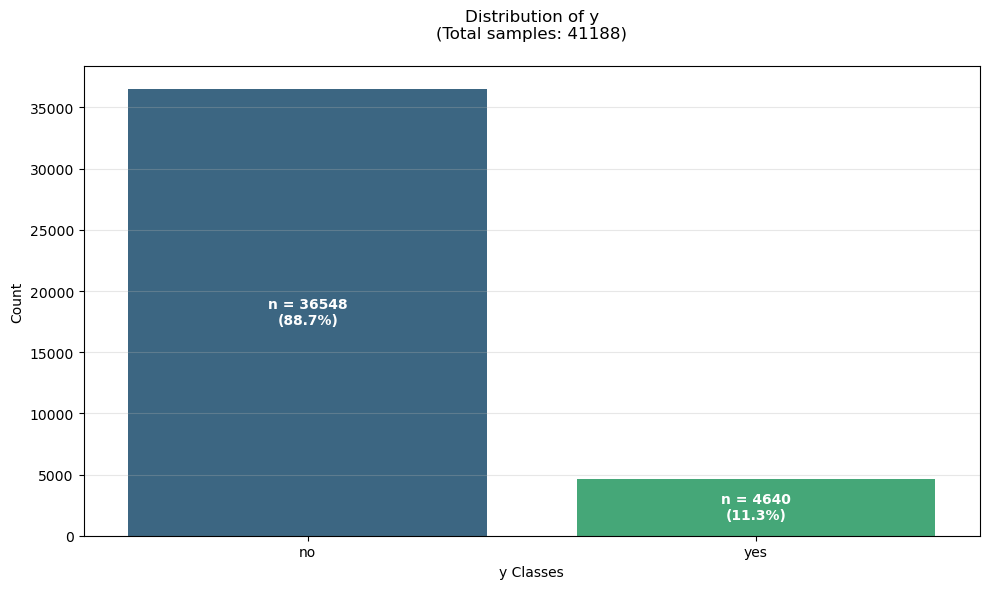

In [12]:
# Plot the target Variable Distribution
plot_target_distribution(data)

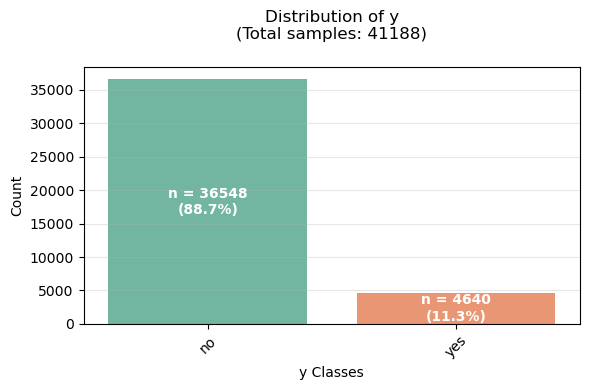

In [13]:
# Customized usage
plot_target_distribution(
    data,
    target_col='y',
    figsize=(6, 4),
    palette='Set2',
    rotation=45
)

In [14]:
# Generate Data Summary
summary = generate_data_summary(data)


Dataset Summary:
✓ Shape: 41188 rows × 21 columns
✓ Numeric Features: 10
✓ Categorical Features: 10
✓ Missing Values: 0 total
✓ Memory Usage: 6.60 MB


In [15]:
# Check the summary keys
print(summary.keys())

dict_keys(['dataset_shape', 'numeric_features', 'categorical_features', 'target_distribution', 'missing_values'])


In [16]:
pprint(summary)

{'categorical_features': {'count': 10,
                          'names': ['job',
                                    'marital',
                                    'education',
                                    'default',
                                    'housing',
                                    'loan',
                                    'contact',
                                    'month',
                                    'day_of_week',
                                    'poutcome'],
                          'unique_values': {'contact': 2,
                                            'day_of_week': 5,
                                            'default': 3,
                                            'education': 8,
                                            'housing': 3,
                                            'job': 12,
                                            'loan': 3,
                                            'marital': 4,
                            

In [17]:
# Access Dataset information
print(f"Dataset shape: {summary['dataset_shape']}")

Dataset shape: (41188, 21)


In [18]:
# Access information about the numeric features
pprint(f"Numeric features: {summary['numeric_features']['names']}")

("Numeric features: ['age', 'duration', 'campaign', 'pdays', 'previous', "
 "'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', "
 "'nr.employed']")


In [19]:
# Access information about categorical features
pprint(f"Target distribution: {summary['target_distribution']}")

("Target distribution: {'distribution': {'no': 0.887, 'yes': 0.113}, 'counts': "
 "{'no': 36548, 'yes': 4640}, 'imbalance_ratio': 0.127, 'majority_class': "
 "'no', 'minority_class': 'yes'}")


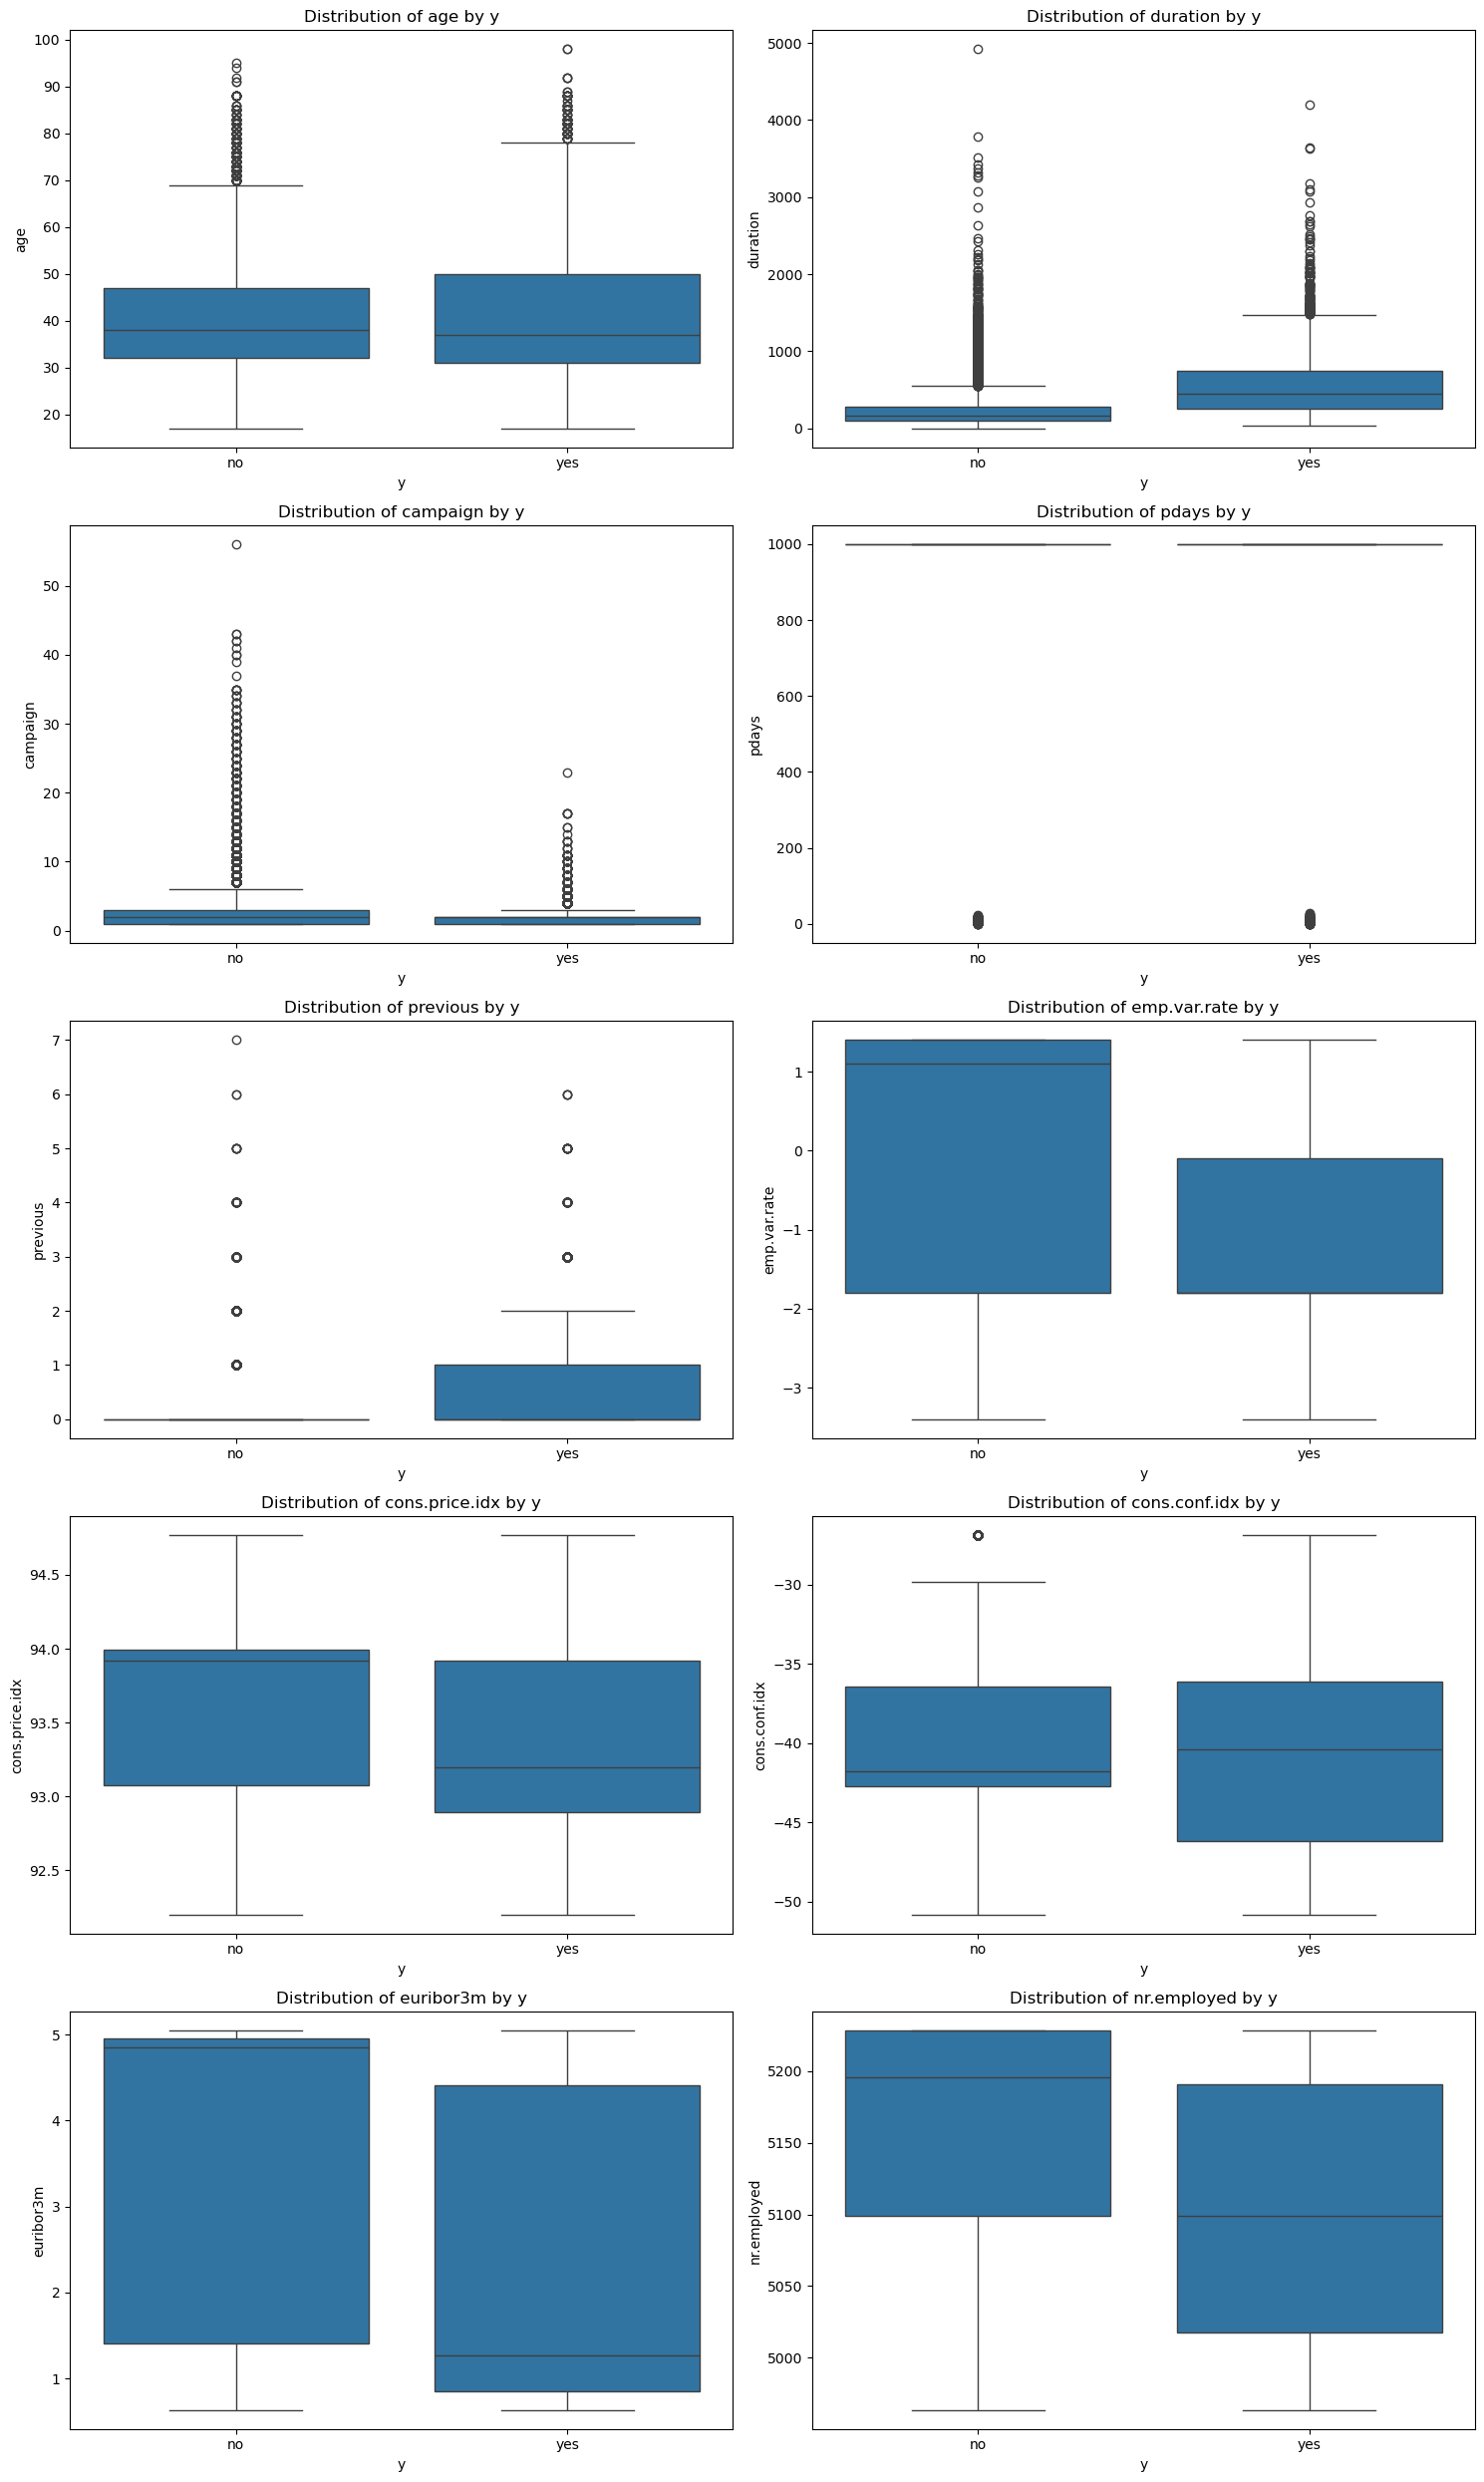

In [20]:
# Visualize the numeric Features
plot_numeric_distributions(data, num_features)

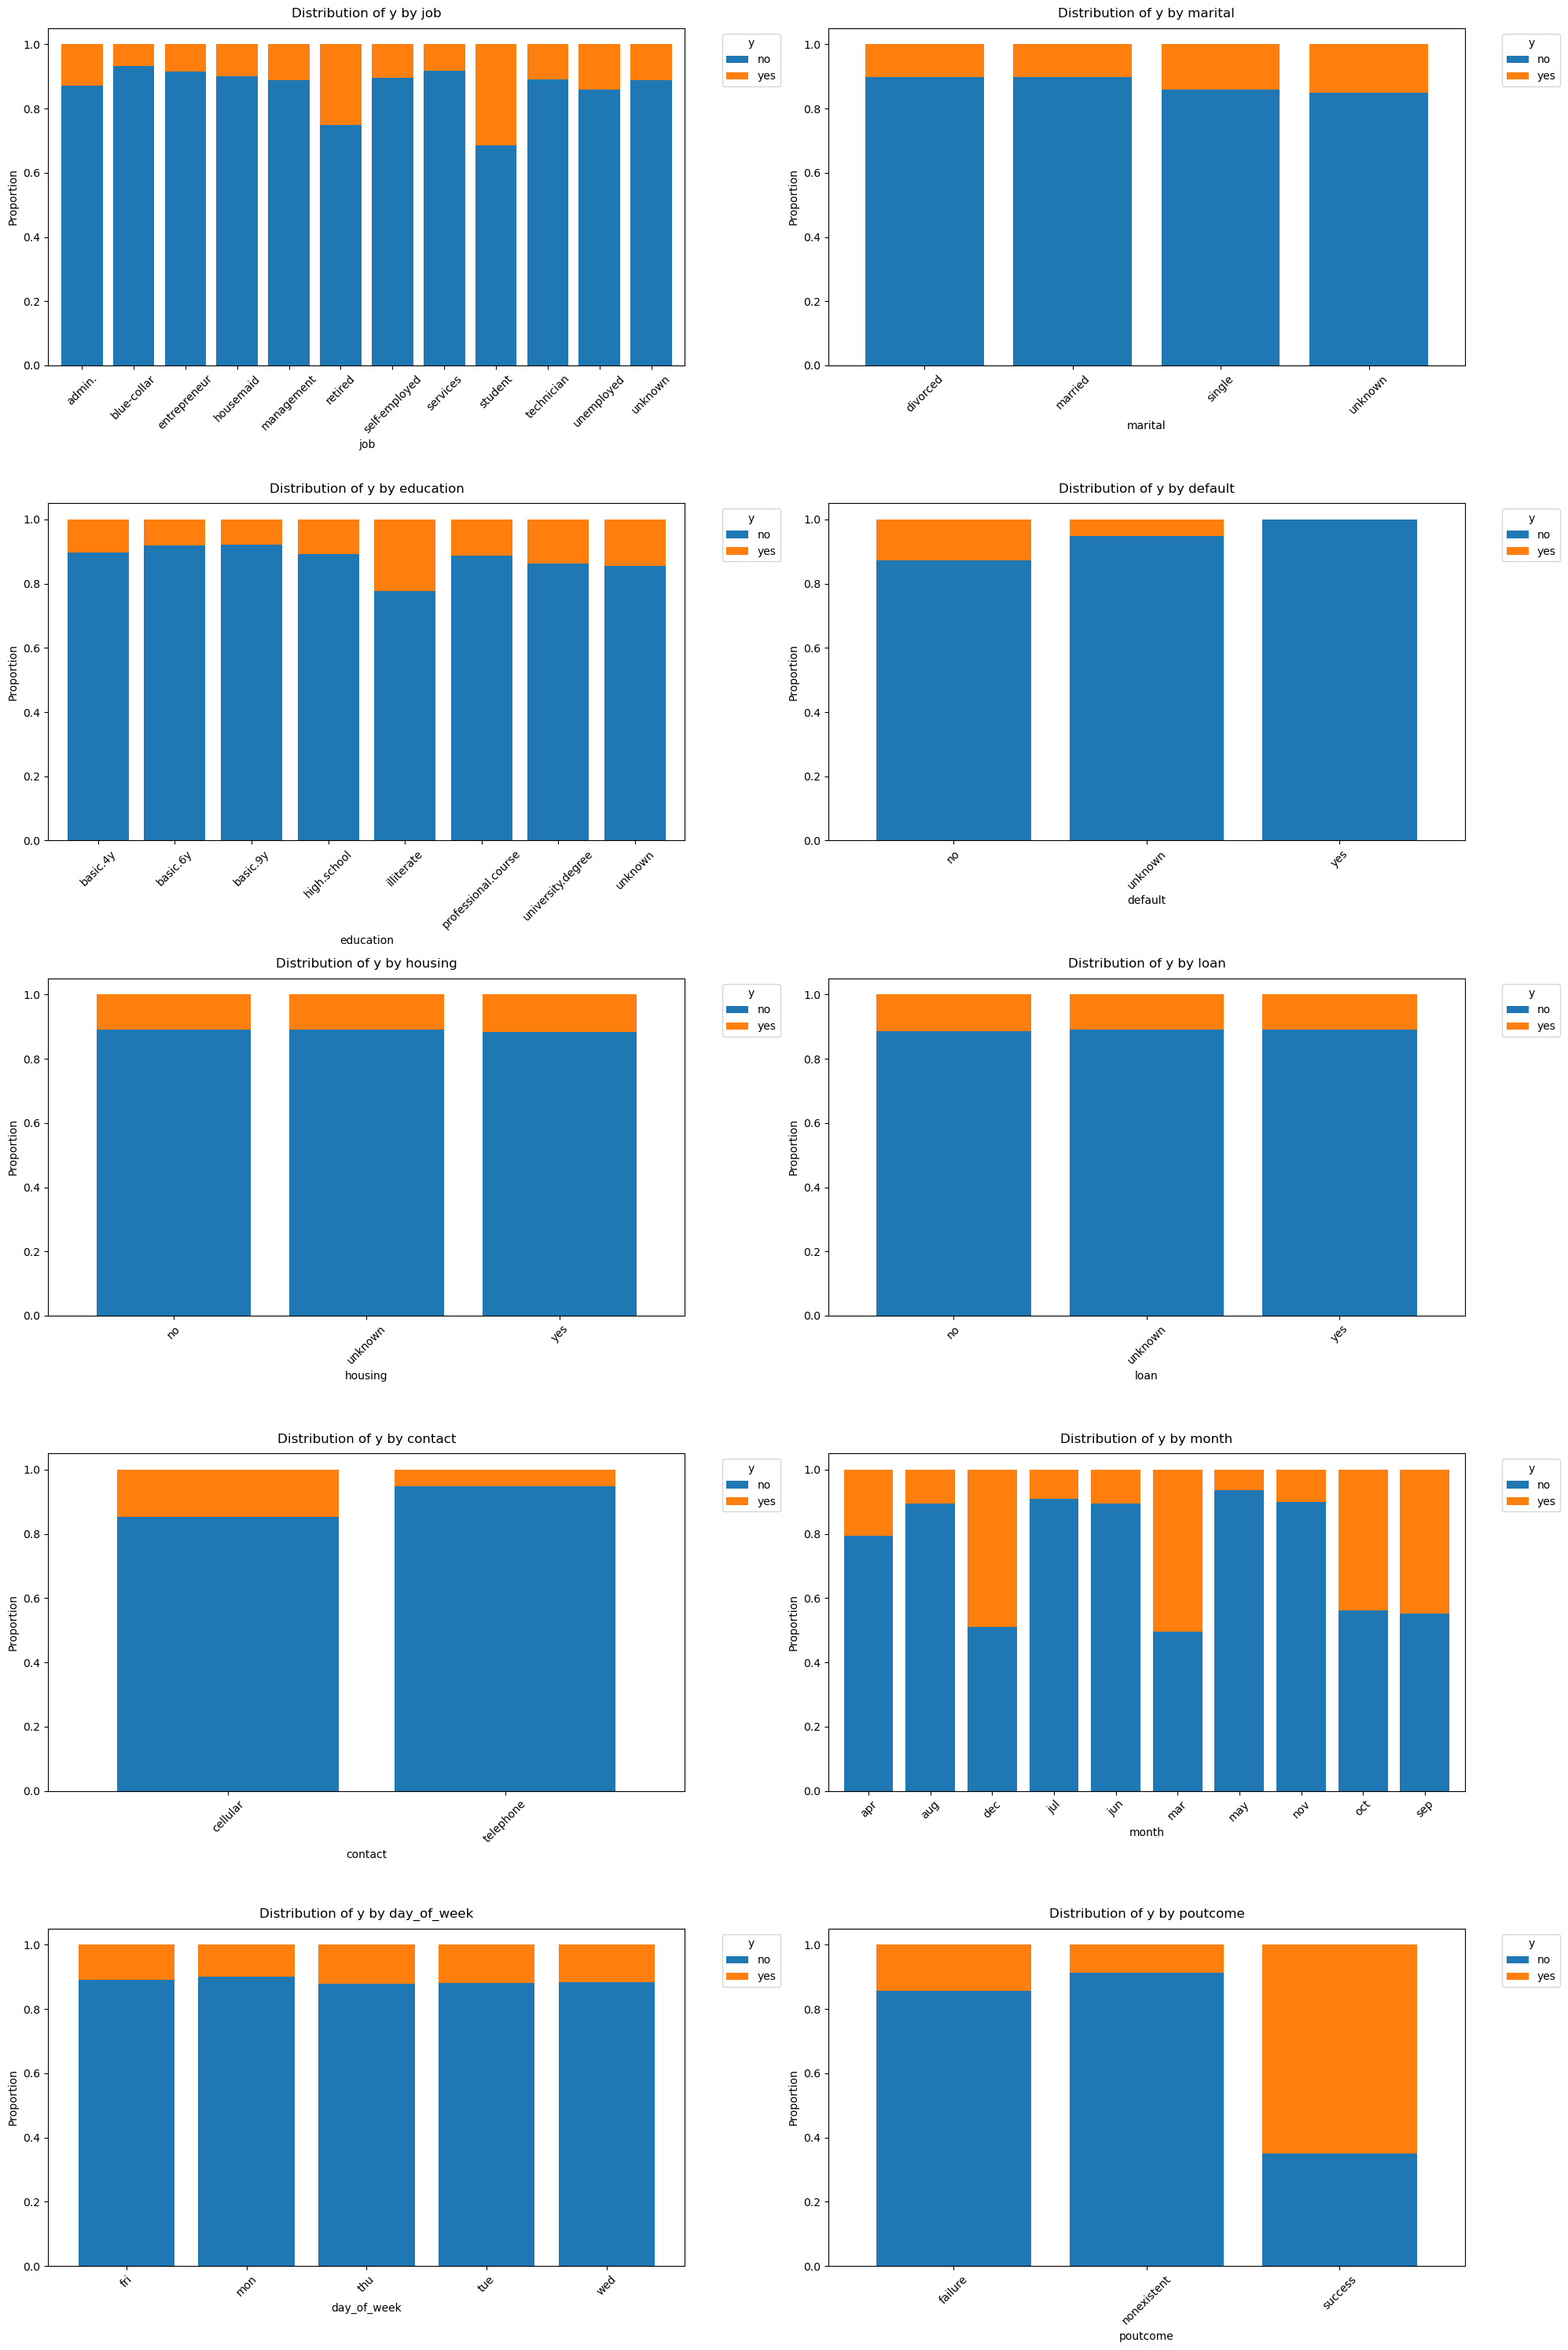

In [21]:
# Visualize Categorical Features
plot_categorical_distributions(data, cat_features)

In [22]:
# Process Numeric Features
df_num_processed, _ = preprocess_numeric_features(data, num_features)
df_num_processed.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [23]:
df_num_processed.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,-1.880382e-16,1.000012,-2.209365,-0.769980,-0.194227,0.669404,5.563310
duration,41188.0,-1.397348e-17,1.000012,-0.996177,-0.602774,-0.301937,0.234171,17.972019
campaign,41188.0,-7.590531e-17,1.000012,-0.565922,-0.565922,-0.204909,0.156105,19.289818
pdays,41188.0,-2.580781e-16,1.000012,-5.149443,0.195414,0.195414,0.195414,0.195414
previous,41188.0,5.520386e-18,1.000012,-0.349494,-0.349494,-0.349494,-0.349494,13.794918
emp.var.rate,41188.0,7.797546e-17,1.000012,-2.216433,-1.197935,0.648092,0.839061,0.839061
cons.price.idx,41188.0,-3.315820e-14,1.000012,-2.374889,-0.864955,0.299457,0.722722,2.058168
cons.conf.idx,41188.0,-1.352495e-16,1.000012,-2.224953,-0.474791,-0.280328,0.886447,2.939106
euribor3m,41188.0,0.000000e+00,1.000012,-1.722351,-1.312994,0.712460,0.772422,0.820853
nr.employed,41188.0,-1.024860e-14,1.000012,-2.815697,-0.940281,0.331680,0.845170,0.845170


In [24]:
# preprocess categorical features
df_processed, _ = encode_categorical_features(df_num_processed, cat_features)
df_processed.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,1.533034,0.010471,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.628993,-0.421501,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.290186,-0.124520,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.002309,-0.413787,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.533034,0.187888,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [25]:
# Encode the target variable
df_processed, _ = encode_target(df_processed, 'y')

In [26]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  float64
 1   duration                       41188 non-null  float64
 2   campaign                       41188 non-null  float64
 3   pdays                          41188 non-null  float64
 4   previous                       41188 non-null  float64
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  y                              41188 non-null  int64  
 11  job_blue-collar                41188 non-null  float64
 12  job_entrepreneur               41188 non-null 

In [27]:
generate_data_summary(data)


Dataset Summary:
✓ Shape: 41188 rows × 21 columns
✓ Numeric Features: 10
✓ Categorical Features: 10
✓ Missing Values: 0 total
✓ Memory Usage: 6.60 MB


{'dataset_shape': (41188, 21),
 'numeric_features': {'count': 10,
  'names': ['age',
   'duration',
   'campaign',
   'pdays',
   'previous',
   'emp.var.rate',
   'cons.price.idx',
   'cons.conf.idx',
   'euribor3m',
   'nr.employed'],
  'statistics': {'age': {'count': 41188.0,
    'mean': 40.02,
    'std': 10.42,
    'min': 17.0,
    '25%': 32.0,
    '50%': 38.0,
    '75%': 47.0,
    'max': 98.0},
   'duration': {'count': 41188.0,
    'mean': 258.29,
    'std': 259.28,
    'min': 0.0,
    '25%': 102.0,
    '50%': 180.0,
    '75%': 319.0,
    'max': 4918.0},
   'campaign': {'count': 41188.0,
    'mean': 2.57,
    'std': 2.77,
    'min': 1.0,
    '25%': 1.0,
    '50%': 2.0,
    '75%': 3.0,
    'max': 56.0},
   'pdays': {'count': 41188.0,
    'mean': 962.48,
    'std': 186.91,
    'min': 0.0,
    '25%': 999.0,
    '50%': 999.0,
    '75%': 999.0,
    'max': 999.0},
   'previous': {'count': 41188.0,
    'mean': 0.17,
    'std': 0.49,
    'min': 0.0,
    '25%': 0.0,
    '50%': 0.0,
    '75

In [28]:
df, _, _ , _ = preprocess_data(data, cat_features, num_features, 'y')

In [29]:
# df.info()

In [30]:
cat_enc,_ = encode_categorical_features(data, cat_features)

In [31]:
cat_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   duration                       41188 non-null  int64  
 2   campaign                       41188 non-null  int64  
 3   pdays                          41188 non-null  int64  
 4   previous                       41188 non-null  int64  
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  y                              41188 non-null  object 
 11  job_blue-collar                41188 non-null  float64
 12  job_entrepreneur               41188 non-null 

In [32]:
compute_balanced_weights(data['y'])

{'no': 0.5634781656999015, 'yes': 4.438362068965517}